In [41]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
from glob import glob
import dask
from scipy.io import loadmat
from scipy.integrate import quad
import gsw

[1026.80913378 1026.80913453 1026.80913529 ... 1027.90651995 1027.90666239
 1027.90682436]


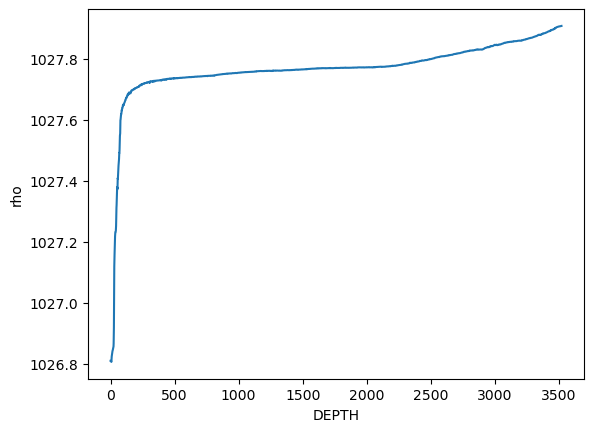

In [45]:
rho0 = 1025.0          # reference density [kg m^-3]
grav = 9.80665         # m/s2



profile = loadmat('/Users/macbookstephan/Library/Mobile Documents/com~apple~CloudDocs/AA Studium/Master/APOTHERM/Exercises/Handout_8/Labrador3.mat').get("rho").T[0]
depths = loadmat('/Users/macbookstephan/Library/Mobile Documents/com~apple~CloudDocs/AA Studium/Master/APOTHERM/Exercises/Handout_8/Labrador3.mat').get("z").T[0]

print(profile)

rho_profile = xr.Dataset(
    data_vars=dict(
        rho=(["DEPTH"], profile),
        ),
    coords=dict(
        depth=("DEPTH", depths),
    ),
)
rho_profile.rho.plot()

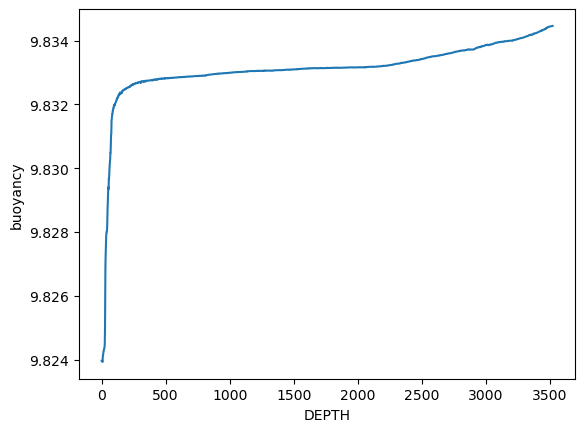

In [47]:
a_profile = rho_profile.assign(buoyancy=grav*rho_profile["rho"]/rho0)
a_profile.buoyancy.plot()

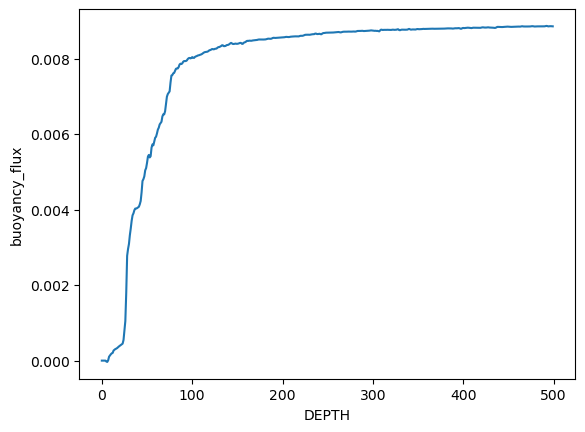

In [49]:
flux_profile = a_profile.assign(buoyancy_flux=a_profile["buoyancy"]-a_profile["buoyancy"].data[0])
flux_profile.sel(DEPTH=slice(0, 500)).buoyancy_flux.plot()

/var/folders/8_/s8jq8h1x6tn75hbn5yz0q5n80000gn/T/ipykernel_26250/3911906986.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sal0  = float(lab_data["sal0"])      # average surface salinity S0


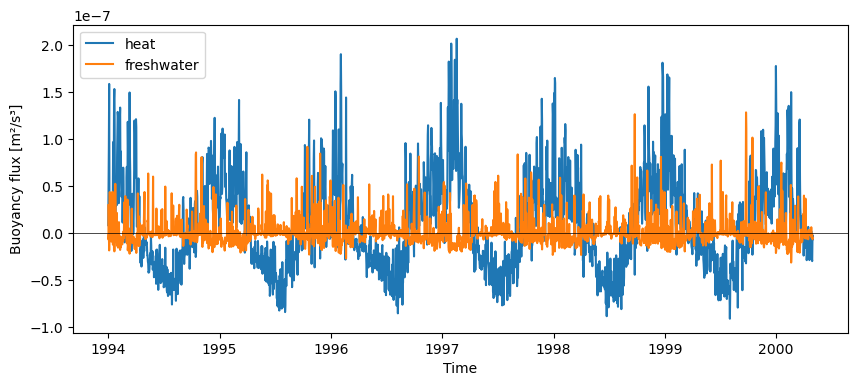

Winter    ∫B_heat dt     ∫B_tot dt      H_heat [m]   H_total [m]
1994/1995   5.116e-01   4.624e-01       107.3       101.3
1995/1996   3.434e-01   3.462e-01        86.3        86.7
1996/1997   6.639e-01   6.397e-01       125.9       123.0
1997/1998   4.434e-01   4.169e-01        98.9        95.6
1998/1999   4.822e-01   4.654e-01       103.7       101.6
1999/2000   4.557e-01   4.262e-01       100.4        96.7


In [51]:
import datetime as dt

# Time series and buoyancy flux at the surface

yy = lab_data["yy"].ravel()
mm = lab_data["mm"].ravel()
dd = lab_data["dd"].ravel()
hh = lab_data["hh"].ravel()

dates = np.array([dt.datetime(int(yy[i]), int(mm[i]), int(dd[i]), int(hh[i]))
                  for i in range(len(yy))])

Qsol  = lab_data["Qsol"].ravel()
Qlong = lab_data["Qlong"].ravel()
Qlat  = lab_data["Qlat"].ravel()
Qsens = lab_data["Qsens"].ravel()

P     = lab_data["P"].ravel()
E     = lab_data["E"].ravel()

c_p   = lab_data["c_p"].ravel()      # heat capacity
alpha = lab_data["alpha"].ravel()    # thermal expansion
beta  = lab_data["beta"].ravel()     # haline expansion
sal0  = float(lab_data["sal0"])      # average surface salinity S0

Q_sum = Qsol + Qlong + Qlat + Qsens

B_heat = -grav * alpha / (rho0 * c_p) * Q_sum          # buoyancy flux from heat
B_fw   =  grav * beta * sal0 * (P - E)                 # buoyancy flux from freshwater
B_tot  = B_heat + B_fw                                 # buoyancy flux total

plt.figure(figsize=(10,4))
plt.plot(dates, B_heat, label="heat")
plt.plot(dates, B_fw,   label="freshwater")
plt.axhline(0, color="k", linewidth=0.5)
plt.ylabel("Buoyancy flux [m²/s³]")
plt.xlabel("Time")
plt.legend()
plt.show()

# Integrated buoyancy vs depth (from A(z) of 1a)

depth_arr = depths
A_arr     = flux_profile["buoyancy_flux"].values  # A(z) [m/s²]

dz   = np.diff(depth_arr)
Amid = 0.5 * (A_arr[:-1] + A_arr[1:])

B_req = np.zeros_like(depth_arr)         # ∫ A(z') dz'  [m²/s²] from 0 to z
B_req[1:] = np.cumsum(Amid * dz)

def convection_depth_from_buoy(B_int):
    return np.interp(B_int, B_req, depth_arr)

# Integrate buoyancy flux over each winter and get depths

def winter_mask(start_year):
    start = dt.datetime(start_year, 12, 1)
    end   = dt.datetime(start_year + 1, 3, 31, 23, 59, 59)
    return (dates >= start) & (dates <= end)

def integrate_buoyancy(B, mask):
    t = np.array([(d - dates[0]).total_seconds() for d in dates[mask]])
    t = t - t[0]
    return np.trapz(B[mask], t)          # ∫ B dt  [m²/s²]

winters = [1994, 1995, 1996, 1997, 1998, 1999]

print("Winter    ∫B_heat dt     ∫B_tot dt      H_heat [m]   H_total [m]")
for sy in winters:
    mask = winter_mask(sy)

    Bint_heat = integrate_buoyancy(B_heat, mask)
    Bint_tot  = integrate_buoyancy(B_tot,  mask)

    H_heat  = convection_depth_from_buoy(Bint_heat)
    H_total = convection_depth_from_buoy(Bint_tot)

    print(f"{sy}/{sy+1}  {Bint_heat:10.3e}  {Bint_tot:10.3e}   {H_heat:9.1f}   {H_total:9.1f}")
